# Goal

* Multiple Regression on Matrices (MRM) analysis on IndD dataset
  * IndD = one sample per individual
  * dependent variable: alpha-diversity
* Intra-species sensitivity analysis: calculating MRM for permutations of samples within each species

# Var

In [1]:
work_dir = '/ebio/abt3_projects/Georg_animal_feces/data/modulating_factors/MRM/IndD/alpha_div/'

# phyloseq
physeq_file = '/ebio/abt3_projects/Georg_animal_feces/data/16S/LLA/phyloseq/physeq_r5k.RDS'

# alpha-div calculated with qiime2
alpha_div_file = '/ebio/abt3_projects/Georg_animal_feces/data/16S/LLA/diversity/alpha_div.RDS'

# host phylogeny distance
host_tree_dist_file = '/ebio/abt3_projects/Georg_animal_feces/data/animal/phylogeny/TT/unified_metadata_complete_20180625_rn_16S-r5k_IndD_dist.RDS'

# params
conda_env = 'qiime2'
threads = 12

# Init

In [2]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(stringr)
library(phyloseq)
source('/ebio/abt3_projects/Georg_animal_feces/code/init.R') 


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [3]:
set.seed(8301)

In [4]:
make_dir(work_dir)
setwd(work_dir)

Directory already exists: /ebio/abt3_projects/Georg_animal_feces/data/modulating_factors/MRM/IndD/alpha_div/ 


## Functions

In [5]:
dist_mtx_order = function(d, x){
    # Ordering distance matrixes
    # d = distance matrix (dist class)
    # x = vector to order dist. obj. by
    m = d %>% as.matrix
    d = as.dist(m[x,x])
    return(d)
}

#m %>% as.vector %>% scale %>% matrix(nrow=3, ncol=3)

In [6]:
rescale_dist_mtx = function(m){
    m = m %>% as.matrix
    labs = m %>% colnames
    n_row = m %>% nrow
    n_col = m %>% ncol
    x = m %>% as.vector 
    x = scales::rescale(x) 
    m = matrix(x, nrow=n_row, ncol=n_col)
    colnames(m) = labs
    rownames(m) = labs
    m = m %>% as.dist
    return(m)
}


# Load

## Alpha diversity

In [7]:
# load alpha-div values
alpha_div = readRDS(alpha_div_file)
alpha_div = do.call(cbind, alpha_div)
alpha_div$X.SampleID = rownames(alpha_div)
alpha_div %>% dfhead

[1] 213   5


,pielou_e,observed_otus,shannon,faith_pd,X.SampleID
X1.Eurasian.Beaver,0.6507254,158,4.752756,16.56554,X1.Eurasian.Beaver
X101.Horse,0.9042161,933,8.920754,59.46621,X101.Horse
X102.Kulan,0.8443325,422,7.363508,35.80528,X102.Kulan


## Phyloseq

In [8]:
physeq = readRDS(physeq_file)
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 30290 taxa and 213 samples ]
sample_data() Sample Data:       [ 213 samples by 171 sample variables ]
tax_table()   Taxonomy Table:    [ 30290 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 30290 tips and 29752 internal nodes ]

### Metadata

In [9]:
metadata = physeq %>%
    sample_data %>%
    as.matrix %>%
    as.data.frame %>%
    mutate(X.SampleID = rownames(.))

metadata %>% dfhead

Warning message in class(X) <- NULL:
“Setting class(x) to NULL;   result will no longer be an S4 object”

[1] 213 171


X.SampleID,BarcodeSequence,LinkerPrimerSequence,Primer,ReversePrimer,Barcode_ID,sample_number,host_subject_id,host_german_name,host_common_name,⋯,wellplate_position_Illumina,Cornell_Dilution_DNA_Illumina,Num_Illumina,Num,sorting_454,comments_additional,DNA_box_20180622,sample_vol_20180622,sample_label_20180622,Description
X1.Eurasian.Beaver,ACTCACGGTATG,CATGCTGCCTCCCGTAGGAGT,GCCTCCCTCGCGCCATCAG,AGAGTTTGATCCTGGCTCAG,338R_BC0049,1,1,Biber,Eurasian.Beaver,⋯,B12,4,120,18,18,NA,1,20,1,NA
X101.Horse,ACGACGTCTTAG,CATGCTGCCTCCCGTAGGAGT,GCCTCCCTCGCGCCATCAG,AGAGTTTGATCCTGGCTCAG,338R_BC0030,101,101,Hauspferd,Horse,⋯,E8,16,344,160,160,NA,2,20,101,NA
X102.Kulan,ACGAGTGCTATC,CATGCTGCCTCCCGTAGGAGT,GCCTCCCTCGCGCCATCAG,AGAGTTTGATCCTGGCTCAG,338R_BC0031,102,102,Khulan,Kulan,⋯,E9,16,345,161,161,NA,2,20,102,NA


## Host phylogeny

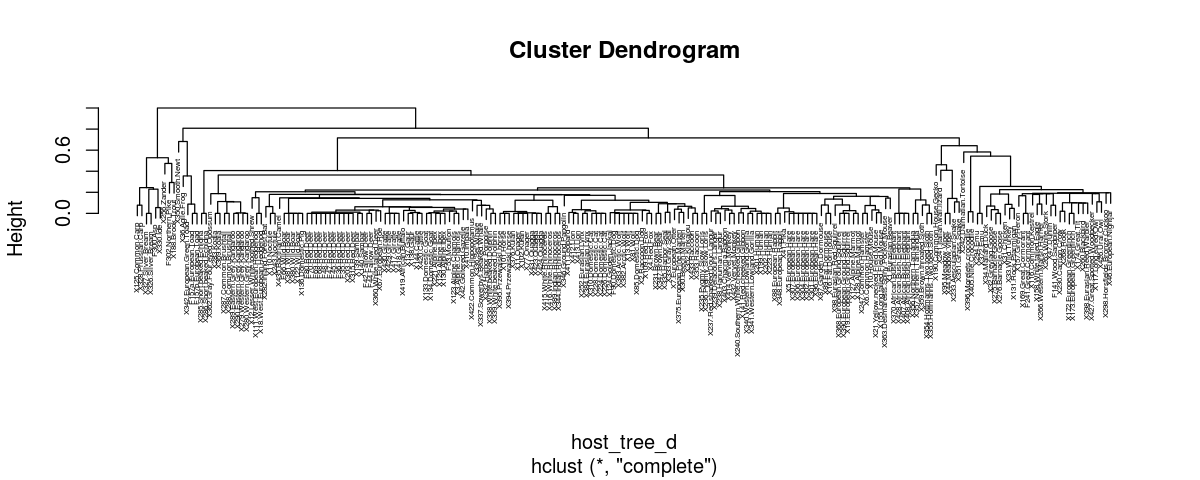

In [10]:
# patristic distance
host_tree_d = readRDS(host_tree_dist_file)
options(repr.plot.height=4, repr.plot.width=10)
plot(hclust(host_tree_d), cex=0.4)

# Making distance matrices

## Alpha diversity

In [11]:
# convert to distance matrices
alpha_div_mtx = list()
n = ncol(alpha_div) -1 
for(x in colnames(alpha_div)[1:n]){
    y = as.data.frame(alpha_div[,x])
    rownames(y) = rownames(alpha_div)
    alpha_div_mtx[[x]] = cluster::daisy(y, metric='gower')
}
alpha_div = alpha_div_mtx    

# status
lapply(alpha_div, function(x) x %>% as.vector %>% summary)

$pielou_e
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000032 0.0809808 0.1826115 0.2265901 0.3156779 1.0000000 

$observed_otus
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.07273 0.21925 0.28200 0.43850 1.00000 

$shannon
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000066 0.1178534 0.2552890 0.2900999 0.4312166 1.0000000 

$faith_pd
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000021 0.0963922 0.2397792 0.2846611 0.4458039 1.0000000 


## Diet (detailed) distance

* Detailed diet categories

In [12]:
metadata %>%
    dplyr::select(X.SampleID, diet_vertebrate, diet_invertebrate, diet_fruit,
                  diet_flowers_nectar_pollen, diet_leaves_branches_bark_buds, diet_seeds,
                  diet_grass_waterplants, diet_roots_tubers) %>% summary

  X.SampleID        diet_vertebrate             diet_invertebrate diet_fruit
 Length:213         no :138         no                   :104     no :124   
 Class :character   yes: 75         yes                  :108     yes: 89   
 Mode  :character                   yes mainly young ones:  1               
 diet_flowers_nectar_pollen diet_leaves_branches_bark_buds diet_seeds
 no :195                    no :112                        no :127   
 yes: 18                    yes:101                        yes: 86   
                                                                     
 diet_grass_waterplants diet_roots_tubers
 no :117                no :143          
 yes: 96                yes: 70          
                                         

In [13]:
dietD = metadata %>%
    dplyr::select(X.SampleID, diet_vertebrate, diet_invertebrate, diet_fruit,
                  diet_flowers_nectar_pollen, diet_leaves_branches_bark_buds, diet_seeds,
                  diet_grass_waterplants, diet_roots_tubers) %>%
    mutate(diet_invertebrate = gsub(' .+', '', diet_invertebrate) %>% as.factor) %>%
    as.data.frame

rownames(dietD) = dietD$X.SampleID
dietD$X.SampleID = NULL

cn = colnames(dietD)
dietD = dietD %>% 
    apply(1, function(x) ifelse(x=='yes', 1, 0)) %>%
    t %>% as.data.frame
colnames(dietD) = cn

# status
dietD %>% head

,diet_vertebrate,diet_invertebrate,diet_fruit,diet_flowers_nectar_pollen,diet_leaves_branches_bark_buds,diet_seeds,diet_grass_waterplants,diet_roots_tubers
X1.Eurasian.Beaver,0,0,0,0,1,0,1,1
X101.Horse,0,0,0,0,0,1,1,0
X102.Kulan,0,0,0,0,1,0,1,0
X109.Red.Fox,1,1,1,0,0,0,0,0
X110.Noctule,0,1,0,0,0,0,0,0
X111.West.European.Hedgehog,1,1,0,0,0,0,0,0


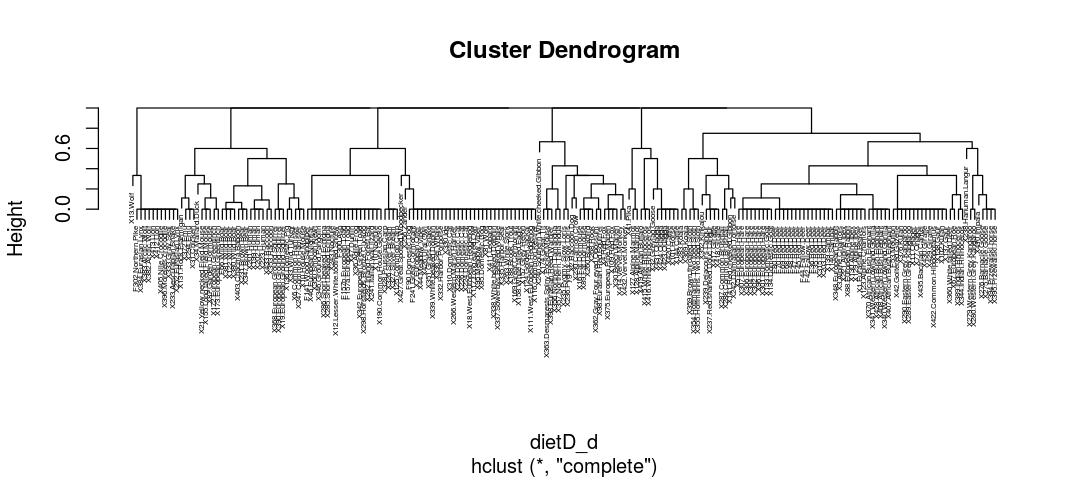

In [14]:
dietD_d = vegan::vegdist(dietD, metric='jaccard')

options(repr.plot.width=9, repr.plot.height=4)
plot(hclust(dietD_d), cex=0.4)

## Digestive tract distance

In [15]:
dtD = metadata %>%
    distinct(X.SampleID, .keep_all=TRUE) %>%
    dplyr::select(X.SampleID, 
                  digestive_system, digestive_system_detail, 
                  ruminant, pseudoruminants) %>%
    mutate(digestive_system = gsub('_', ' ', digestive_system),
           digestive_system_detail = gsub('^_', '', digestive_system_detail),
           digestive_system_detail = gsub('_', ' ', digestive_system_detail),
           digestive_system_detail = gsub(' +', ' ', digestive_system_detail)) %>%
    mutate(digestive_system = digestive_system %>% as.factor,
           digestive_system_detail = digestive_system_detail %>% as.factor) %>%
    as.data.frame

rownames(dtD) = dtD$X.SampleID
dtD$X.SampleID = NULL

dtD %>% head

,digestive_system,digestive_system_detail,ruminant,pseudoruminants
X1.Eurasian.Beaver,hindgut,hindgut,no,no
X101.Horse,hindgut,hindgut,no,no
X102.Kulan,hindgut,hindgut,no,no
X109.Red.Fox,simple,simple,no,no
X110.Noctule,NA,NA,no,no
X111.West.European.Hedgehog,simple,simple,no,no


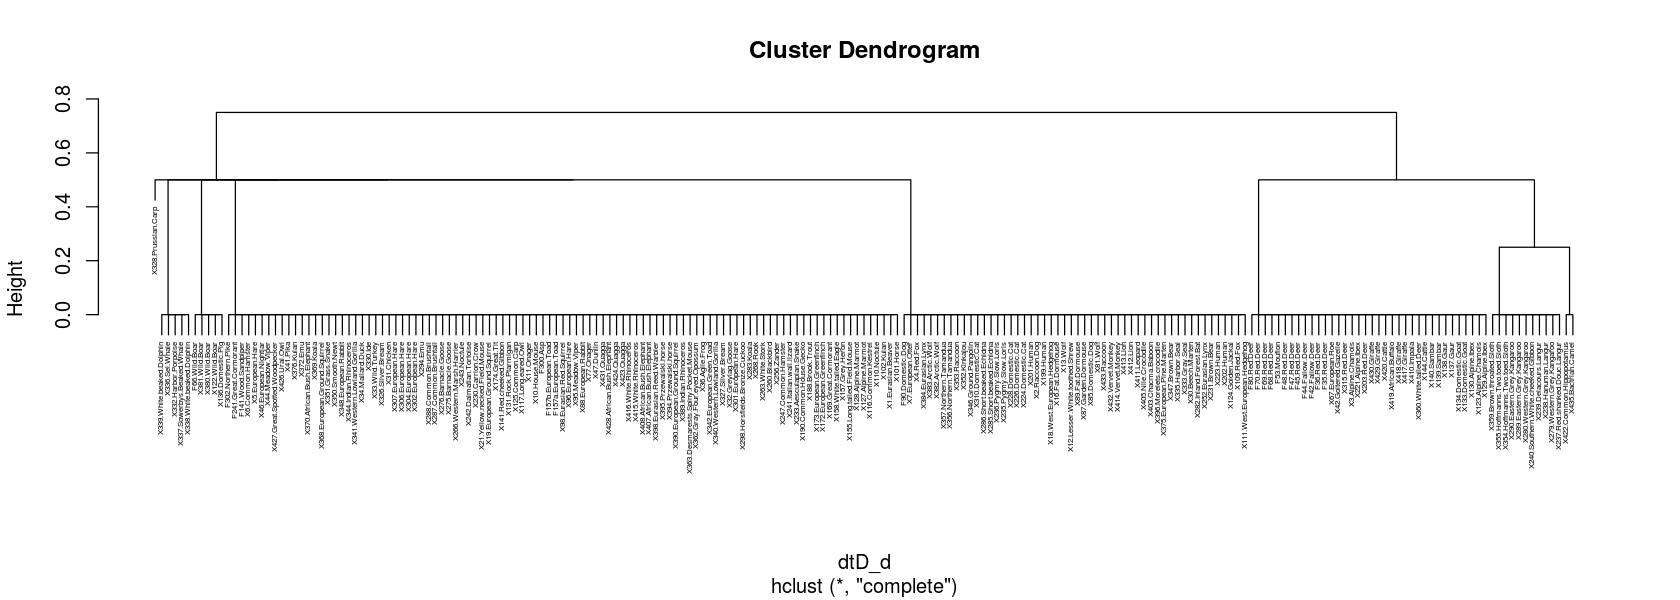

In [16]:
dtD_d = cluster::daisy(dtD, metric='gower')

options(repr.plot.height=5, repr.plot.width=14)
plot(hclust(dtD_d), cex=0.4)

## Habitat distance

* Gower distance on `habitat_detail`

In [17]:
metadata$habitat_detail %>% table %>% print
metadata$habitat_detail_1 %>% table %>% print
metadata$habitat_detail_2 %>% table %>% print

.
anthropogenic habitat    cultivated habitat    freshwater habitat 
                   11                    10                     9 
            grassland  saline water habitat   terrestrial habitat 
                   33                     7                    95 
             woodland 
                   48 
.
anthropogenic habitat    cultivated habitat                forest 
                   11                    10                    48 
   freshwater habitat             grassland        marine habitat 
                    9                     2                     7 
               meadow               pasture                steppe 
                   15                     4                    12 
  terrestrial habitat 
                   95 
.
anthropogenic habitat    cultivated habitat          flood meadow 
                   11                    10                    15 
               forest    freshwater habitat             grassland 
                   48          

In [18]:
habitatD = metadata %>%
    dplyr::select(X.SampleID, habitat_detail, habitat_detail_1, habitat_detail_2) %>%
    as.data.frame

rownames(habitatD) = habitatD$X.SampleID
habitatD$X.SampleID = NULL

habitatD %>% dfhead

[1] 213   3


,habitat_detail,habitat_detail_1,habitat_detail_2
X1.Eurasian.Beaver,terrestrial habitat,terrestrial habitat,terrestrial habitat
X101.Horse,grassland,pasture,pasture
X102.Kulan,grassland,steppe,steppe


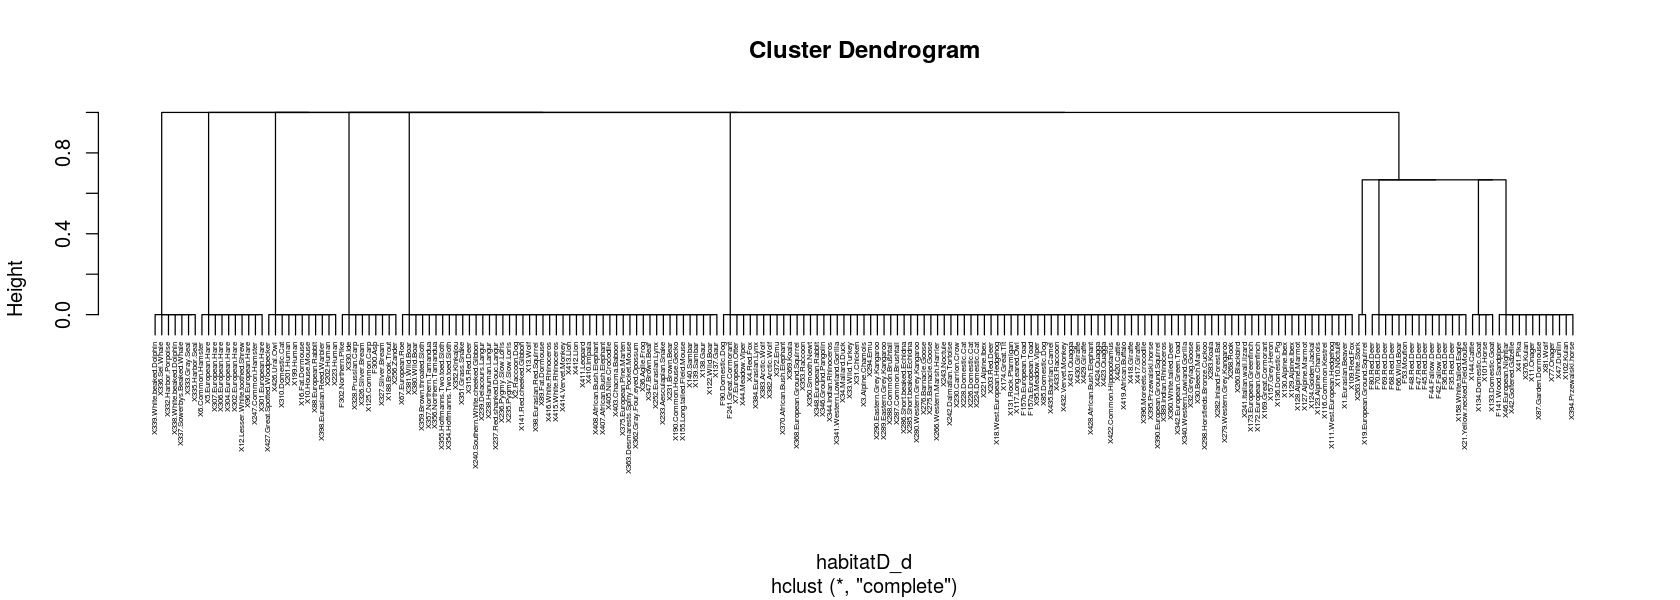

In [19]:
habitatD_d = cluster::daisy(habitatD, metric='gower') 

options(repr.plot.height=5, repr.plot.width=14)
plot(hclust(habitatD_d), cex=0.4)

## Geographic distance

In [20]:
geo = metadata %>% 
    dplyr::select(X.SampleID, latitude, longitude) %>%
    mutate(latitude = latitude %>% as.Num,
           longitude = longitude %>% as.Num) %>%
    as.data.frame

rownames(geo) = geo$X.SampleID

geo$latitude %>% summary %>% print
geo$longitude %>% summary %>% print
geo %>% dfhead    

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -35.83   20.32   47.76   33.32   48.21   55.29 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -84.10   15.61   16.37   26.70   19.05  140.12 
[1] 213   3


,X.SampleID,latitude,longitude
X1.Eurasian.Beaver,X1.Eurasian.Beaver,48.47611,16.58389
X101.Horse,X101.Horse,48.78333,15.06667
X102.Kulan,X102.Kulan,43.70759,98.34961


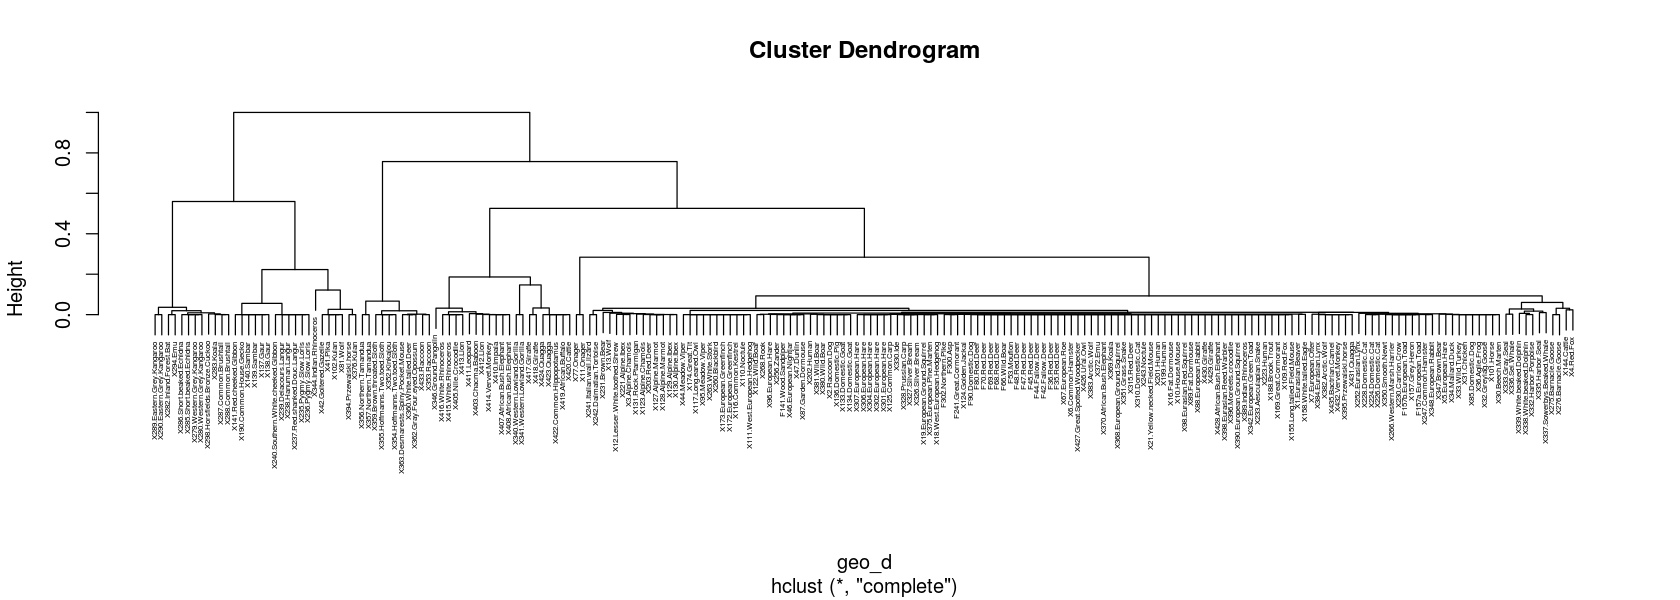

In [21]:
.pairwise_distGeo = function(x, y){
    d = geosphere::distGeo(x[c('longitude', 'latitude')],
                           y[,c('longitude', 'latitude')])
    return(d)
}

pairwise_distGeo = function(df){
    x = df[,c('longitude', 'latitude')]
    geo_d = apply(x, 1, .pairwise_distGeo, y=x)
    rescale_dist_mtx(as.dist(geo_d))
}

geo_d = pairwise_distGeo(geo)

options(repr.plot.height=5, repr.plot.width=14)
plot(hclust(geo_d), cex=0.4)

## Sampling details distance

* Gower distance of sampling methodology
  * assessing variance explained by technical factors

In [22]:
x = metadata$sampling_method %>% unique %>% as.vector
samp = metadata %>% 
    dplyr::select(X.SampleID, sampling_method, captive_wild, wild_domesticated) 

rownames(samp) = samp$X.SampleID
samp$X.SampleID = NULL

samp %>% dfhead

[1] 213   3


,sampling_method,captive_wild,wild_domesticated
X1.Eurasian.Beaver,feces sampling,wild,wild
X101.Horse,feces sampling,captive,domesticated
X102.Kulan,feces sampling,wild,wild


In [23]:
# summary
samp %>% summary

             sampling_method  captive_wild    wild_domesticated
 dried feces sampling:  7    captive: 39   domesticated: 17    
 feces sampling      :179    human  :  4   wild        :196    
 gut section         : 14    wild   :170                       
 swab                : 13                                      

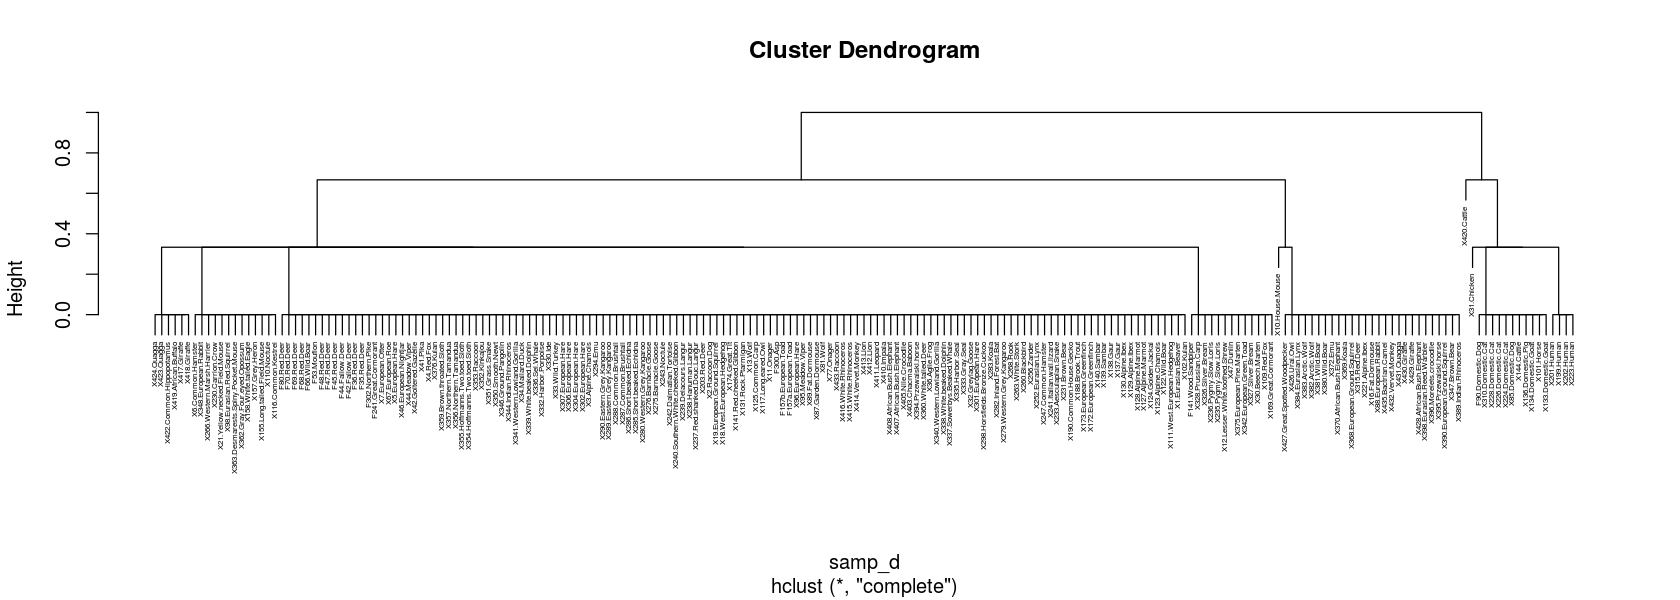

In [24]:
# distance matrix
samp_d = cluster::daisy(samp, metric='gower') 

options(repr.plot.height=5, repr.plot.width=14)
plot(hclust(samp_d), cex=0.4)

# Order matrices

In [25]:
# beta-div labels
alpha_div %>% labels

[1] "pielou_e"      "observed_otus" "shannon"       "faith_pd"

In [26]:
# ordering by beta-div metrix
X = labels(alpha_div$shannon)
host_tree_d_o = dist_mtx_order(host_tree_d, X)
dietD_d_o = dist_mtx_order(dietD_d, X)
habitatD_d_o = dist_mtx_order(habitatD_d, X)
geo_d_o = dist_mtx_order(geo_d, X)
samp_d_o = dist_mtx_order(samp_d, X)
dtD_d_o = dist_mtx_order(dtD_d, X)

In [27]:
# check
X %>% length %>% print
dtD_d_o %>% labels %>% length %>% print

[1] 213
[1] 213


# MRM intra-spec sensitivity

* removing individuals/clades and assessing change in coef.

In [28]:
# number of permutated SpecD datasetst
nperm_datasets = 100
# number of permutations per MRM analysis
nperm = 1000

## Functions

In [29]:
#' randomly selecting one per group
#' L : list of distance matrixes used for MRM
#' df_grps : data.frame (sample, group)
one_per_group = function(L, df_grps, ...){
    # get subsample
    colnames(df_grps) = c('Sample', 'Group')
    df_grps = df_grps %>%
        group_by(Group) %>%
        sample_n(1)
    # subsetting all matrices
    lapply(L, function(x) dist_mtx_order(x, df_grps$Sample))
}

In [30]:
#' MRM on one subsample rep
#' i : rep number
#' L : list of list of distance matrices generated by `one_per_group()`
# nperm : nperm function for MRM
# f : MRM fomulat
mrm_each = function(i, L, f, nperm=99){
    m = L[[i]]
    f = as.formula(f)
    x = ecodist::MRM(f, nperm=nperm, mrank=TRUE)
    # coefficients
    df = x$coef %>% as.data.frame
    colnames(df) = c('coef', 'coef_pval')
    df$variable = rownames(df)
    df$R2 = x$r.squared[1]
    df$pval = x$r.squared[2]
    df$F = x$F.test[1]
    df$rep = i
    return(df)
}

In [31]:
# renaming output
rename_df = data.frame(old_name = c('m$diet', 'm$digest', 'm$geo', 'm$habitat', 'm$host_phy', 'm$samp'),
                       new_name = c('Diet', 'Digestive\nsystem', 'Geography', 'Habitat', 'Phylogeny', 'Technical'))

## One per species

In [32]:
# grouping samples by species
df_grps = metadata %>% 
    filter(X.SampleID %in% labels(dietD_d_o)) %>%
    dplyr::select(X.SampleID, scientific_name)
df_grps %>% dfhead

[1] 213   2


X.SampleID,scientific_name
X1.Eurasian.Beaver,Castor_fiber
X101.Horse,Equus_caballus
X102.Kulan,Equus_hemionus


### Faith's PD

In [33]:
# creating subsample permutations of the distance matrices
L = list(alpha = alpha_div$faith_pd,
         host_phy = host_tree_d_o,
         diet = dietD_d_o,
         digest = dtD_d_o, 
         habitat = habitatD_d_o,
         geo = geo_d_o,
         samp = samp_d_o)

m_perm = lapply(as.list(1:nperm_datasets), function(x) one_per_group(L, df_grps, x))
m_perm %>% length           

[1] 100

In [34]:
# check on sample size
m_perm[[1]][[1]] %>% as.matrix %>% dim

[1] 128 128

#### Model 1

In [35]:
doParallel::registerDoParallel(threads)
x = as.list(1:length(m_perm))
f = 'm$alpha ~ m$host_phy + m$diet + m$digest + m$habitat + m$geo + m$samp'
mrm_res = plyr::llply(x, mrm_each, L=m_perm, f=f, nperm=nperm, .parallel=TRUE)
mrm_res = do.call(rbind, mrm_res)
mrm_res %>% dfhead

[1] 700   7


,coef,coef_pval,variable,R2,pval,F,rep
Int,2.045939e+03,1.000,Int,0.1536812,0.001,245.7792,1
m$host_phy,7.096248e-03,0.839,m$host_phy,0.1536812,0.001,245.7792,1
m$diet,2.382463e-01,0.001,m$diet,0.1536812,0.001,245.7792,1


In [36]:
# summary of overall model
mrm_res %>%
    distinct(R2, pval, rep) %>%
    summary

       R2              pval            rep        
 Min.   :0.1160   Min.   :0.001   Min.   :  1.00  
 1st Qu.:0.1377   1st Qu.:0.001   1st Qu.: 25.75  
 Median :0.1501   Median :0.001   Median : 50.50  
 Mean   :0.1492   Mean   :0.001   Mean   : 50.50  
 3rd Qu.:0.1574   3rd Qu.:0.001   3rd Qu.: 75.25  
 Max.   :0.1956   Max.   :0.001   Max.   :100.00  

Warning message:
“Column `variable`/`old_name` joining character vector and factor, coercing into character vector”

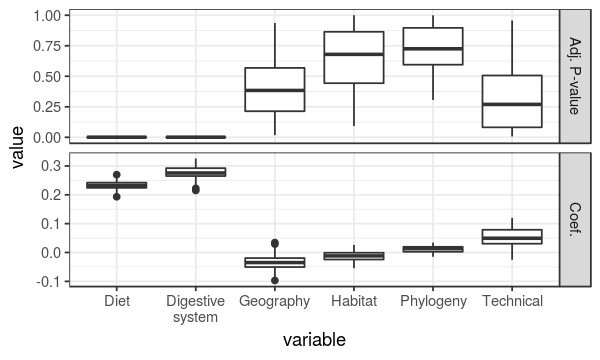

In [37]:
mrm_res_s = mrm_res %>% 
    filter(variable != 'Int') %>%
    gather(category, value, -variable, -R2, -pval, -F, -rep) %>%
    mutate(category = ifelse(category == 'coef', 'Coef.', 'Adj. P-value'))

mrm_res_s = mrm_res_s %>%
    inner_join(rename_df, c('variable'='old_name')) %>%
    dplyr::select(-variable) %>%
    rename('variable' = new_name)             

p = ggplot(mrm_res_s, aes(variable, value)) +
    geom_boxplot() +
    facet_grid(category ~ ., scales='free_y') +
    theme_bw()

options(repr.plot.width=5, repr.plot.height=3)
plot(p)

In [38]:
# significance
mrm_res %>% 
    group_by(variable) %>%
    summarize(pval_sensitivity = 1 - sum(coef_pval < 0.05) / length(pval)) %>%
    ungroup() %>%
    mutate(sig_pval_sensitivity = pval_sensitivity < 0.05)

variable,pval_sensitivity,sig_pval_sensitivity
Int,1.00,FALSE
m$diet,0.00,TRUE
m$digest,0.00,TRUE
m$geo,0.97,FALSE
m$habitat,1.00,FALSE
m$host_phy,1.00,FALSE
m$samp,0.86,FALSE


#### Model 2

In [39]:
doParallel::registerDoParallel(threads)
x = as.list(1:length(m_perm))
f = 'm$alpha ~ m$host_phy + m$diet + m$habitat + m$geo + m$samp'
mrm_res = plyr::llply(x, mrm_each, L=m_perm, f=f, nperm=nperm, .parallel=TRUE)
mrm_res = do.call(rbind, mrm_res)
mrm_res %>% dfhead

[1] 600   7


,coef,coef_pval,variable,R2,pval,F,rep
Int,2987.47385247,0.998,Int,0.1008898,0.001,182.275,1
m$host_phy,-0.07344583,0.043,m$host_phy,0.1008898,0.001,182.275,1
m$diet,0.31804199,0.001,m$diet,0.1008898,0.001,182.275,1


In [40]:
# summary of overall model
mrm_res %>%
    distinct(R2, pval, rep) %>%
    summary

       R2               pval            rep        
 Min.   :0.07276   Min.   :0.001   Min.   :  1.00  
 1st Qu.:0.09271   1st Qu.:0.001   1st Qu.: 25.75  
 Median :0.09960   Median :0.001   Median : 50.50  
 Mean   :0.10025   Mean   :0.001   Mean   : 50.50  
 3rd Qu.:0.10734   3rd Qu.:0.001   3rd Qu.: 75.25  
 Max.   :0.12868   Max.   :0.001   Max.   :100.00  

Warning message:
“Column `variable`/`old_name` joining character vector and factor, coercing into character vector”

File written: /ebio/abt3_projects/Georg_animal_feces/data/modulating_factors/MRM/IndD/alpha_div/.figures/MRM_IndD_faithPD_model2.pdf 


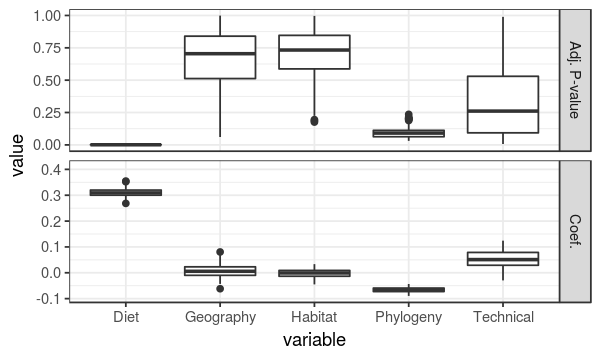

In [41]:
mrm_res_s = mrm_res %>% 
    filter(variable != 'Int') %>%
    gather(category, value, -variable, -R2, -pval, -F, -rep) %>%
    mutate(category = ifelse(category == 'coef', 'Coef.', 'Adj. P-value'))

mrm_res_s = mrm_res_s %>%
    inner_join(rename_df, c('variable'='old_name')) %>%
    dplyr::select(-variable) %>%
    rename('variable' = new_name)             

# changing coef scale
df = mrm_res_s %>%
    filter(category == 'Coef.') %>%
    mutate(value = 0.41) %>%
    .[1,]

# plotting
p = ggplot(mrm_res_s, aes(variable, value)) +
    geom_boxplot() +
    geom_point(data=df, alpha=0) +
    facet_grid(category ~ ., scales='free_y') +
    theme_bw()

options(repr.plot.width=5, repr.plot.height=3)
plot_write(p, file='MRM_IndD_faithPD_model2.pdf')

In [42]:
# significance
mrm_res %>% 
    group_by(variable) %>%
    summarize(pval_sensitivity = 1 - sum(coef_pval < 0.05) / length(pval)) %>%
    ungroup() %>%
    mutate(sig_pval_sensitivity = pval_sensitivity < 0.05)

variable,pval_sensitivity,sig_pval_sensitivity
Int,1.00,FALSE
m$diet,0.00,TRUE
m$geo,1.00,FALSE
m$habitat,1.00,FALSE
m$host_phy,0.87,FALSE
m$samp,0.86,FALSE


### Shannon

In [43]:
# creating multiple distance matrices
L = list(alpha = alpha_div$shannon,
         host_phy = host_tree_d_o,
         diet = dietD_d_o,
         digest = dtD_d_o, 
         habitat = habitatD_d_o,
         geo = geo_d_o,
         samp = samp_d_o)

m_perm = lapply(as.list(1:nperm_datasets), function(x) one_per_group(L, df_grps, x))
m_perm %>% length           

[1] 100

In [44]:
# check on sample size
m_perm[[1]][[1]] %>% as.matrix %>% dim

[1] 128 128

#### Model 1

In [45]:
doParallel::registerDoParallel(threads)
x = as.list(1:length(m_perm))
f = 'm$alpha ~ m$host_phy + m$diet + m$digest + m$habitat + m$geo + m$samp'
mrm_res = plyr::llply(x, mrm_each, L=m_perm, f=f, nperm=nperm, .parallel=TRUE)
mrm_res = do.call(rbind, mrm_res)
mrm_res %>% dfhead

[1] 700   7


,coef,coef_pval,variable,R2,pval,F,rep
Int,2.987321e+03,0.998,Int,0.06118889,0.001,88.21707,1
m$host_phy,7.982637e-04,0.979,m$host_phy,0.06118889,0.001,88.21707,1
m$diet,2.116983e-01,0.001,m$diet,0.06118889,0.001,88.21707,1


In [46]:
# summary of overall model
mrm_res %>%
    distinct(R2, pval, rep) %>%
    summary

       R2               pval              rep        
 Min.   :0.03494   Min.   :0.00100   Min.   :  1.00  
 1st Qu.:0.05073   1st Qu.:0.00100   1st Qu.: 25.75  
 Median :0.05988   Median :0.00100   Median : 50.50  
 Mean   :0.05958   Mean   :0.00102   Mean   : 50.50  
 3rd Qu.:0.06799   3rd Qu.:0.00100   3rd Qu.: 75.25  
 Max.   :0.09767   Max.   :0.00200   Max.   :100.00  

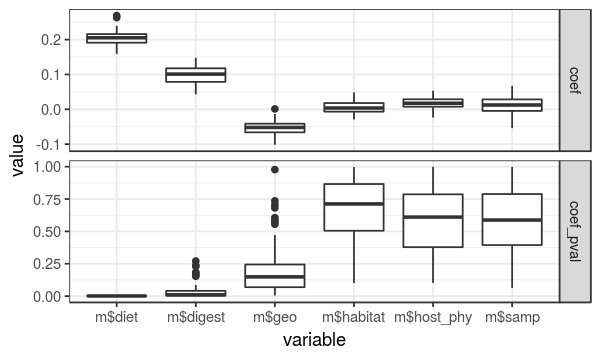

In [47]:
mrm_res_s = mrm_res %>% 
    filter(variable != 'Int') %>%
    gather(category, value, -variable, -R2, -pval, -F, -rep)              

p = ggplot(mrm_res_s, aes(variable, value)) +
    geom_boxplot() +
    facet_grid(category ~ ., scales='free_y') +
    theme_bw()

options(repr.plot.width=5, repr.plot.height=3)
plot(p)

In [48]:
# significance
mrm_res %>% 
    group_by(variable) %>%
    summarize(pval_sensitivity = 1 - sum(coef_pval < 0.05) / length(pval)) %>%
    ungroup() %>%
    mutate(sig_pval_sensitivity = pval_sensitivity < 0.05)

variable,pval_sensitivity,sig_pval_sensitivity
Int,1.00,FALSE
m$diet,0.00,TRUE
m$digest,0.20,FALSE
m$geo,0.84,FALSE
m$habitat,1.00,FALSE
m$host_phy,1.00,FALSE
m$samp,1.00,FALSE


#### Model 2

In [49]:
doParallel::registerDoParallel(threads)
x = as.list(1:length(m_perm))
f = 'm$alpha ~ m$host_phy + m$diet + m$habitat + m$geo + m$samp'
mrm_res = plyr::llply(x, mrm_each, L=m_perm, f=f, nperm=nperm, .parallel=TRUE)
mrm_res = do.call(rbind, mrm_res)
mrm_res %>% dfhead

[1] 600   7


,coef,coef_pval,variable,R2,pval,F,rep
Int,3302.27111130,0.989,Int,0.0545876,0.001,93.79197,1
m$host_phy,-0.02721078,0.368,m$host_phy,0.0545876,0.001,93.79197,1
m$diet,0.23997340,0.001,m$diet,0.0545876,0.001,93.79197,1


In [50]:
# summary of overall model
mrm_res %>%
    distinct(R2, pval, rep) %>%
    summary

       R2               pval              rep        
 Min.   :0.03134   Min.   :0.00100   Min.   :  1.00  
 1st Qu.:0.04617   1st Qu.:0.00100   1st Qu.: 25.75  
 Median :0.05250   Median :0.00100   Median : 50.50  
 Mean   :0.05298   Mean   :0.00102   Mean   : 50.50  
 3rd Qu.:0.05937   3rd Qu.:0.00100   3rd Qu.: 75.25  
 Max.   :0.08898   Max.   :0.00200   Max.   :100.00  

Warning message:
“Column `variable`/`old_name` joining character vector and factor, coercing into character vector”

File written: /ebio/abt3_projects/Georg_animal_feces/data/modulating_factors/MRM/IndD/alpha_div/.figures/MRM_IndD_shannon_model2.pdf 


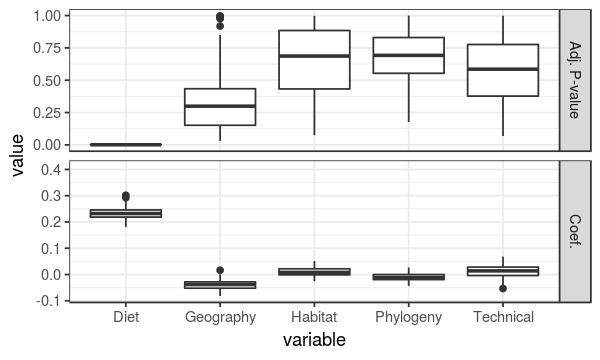

In [51]:
mrm_res_s = mrm_res %>% 
    filter(variable != 'Int') %>%
    gather(category, value, -variable, -R2, -pval, -F, -rep) %>%
    mutate(category = ifelse(category == 'coef', 'Coef.', 'Adj. P-value'))

mrm_res_s = mrm_res_s %>%
    inner_join(rename_df, c('variable'='old_name')) %>%
    dplyr::select(-variable) %>%
    rename('variable' = new_name)              

# changing coef scale
df = mrm_res_s %>%
    filter(category == 'Coef.') %>%
    mutate(value = 0.41) %>%
    .[1,]

# plotting
p = ggplot(mrm_res_s, aes(variable, value)) +
    geom_boxplot() +
    geom_point(data=df, alpha=0) +
    facet_grid(category ~ ., scales='free_y') +
    theme_bw()

options(repr.plot.width=5, repr.plot.height=3)
plot_write(p, file='MRM_IndD_shannon_model2.pdf')

In [52]:
# significance
mrm_res %>% 
    group_by(variable) %>%
    summarize(pval_sensitivity = 1 - sum(coef_pval < 0.05) / length(pval)) %>%
    ungroup() %>%
    mutate(sig_pval_sensitivity = pval_sensitivity < 0.05)

variable,pval_sensitivity,sig_pval_sensitivity
Int,1.00,FALSE
m$diet,0.00,TRUE
m$geo,0.96,FALSE
m$habitat,1.00,FALSE
m$host_phy,1.00,FALSE
m$samp,1.00,FALSE


### Evenness

In [53]:
# creating multiple distance matrices
L = list(alpha = alpha_div$pielou_e,
         host_phy = host_tree_d_o,
         diet = dietD_d_o,
         digest = dtD_d_o, 
         habitat = habitatD_d_o,
         geo = geo_d_o,
         samp = samp_d_o)

m_perm = lapply(as.list(1:nperm_datasets), function(x) one_per_group(L, df_grps, x))
m_perm %>% length           

[1] 100

In [54]:
# check on sample size
m_perm[[1]][[1]] %>% as.matrix %>% dim

[1] 128 128

#### Model 1

In [55]:
doParallel::registerDoParallel(threads)
x = as.list(1:length(m_perm))
f = 'm$alpha ~ m$host_phy + m$diet + m$digest + m$habitat + m$geo + m$samp'
mrm_res = plyr::llply(x, mrm_each, L=m_perm, f=f, nperm=nperm, .parallel=TRUE)
mrm_res = do.call(rbind, mrm_res)
mrm_res %>% dfhead

[1] 700   7


,coef,coef_pval,variable,R2,pval,F,rep
Int,3.766408e+03,0.788,Int,0.0102923,0.349,14.0755,1
m$host_phy,6.513751e-02,0.153,m$host_phy,0.0102923,0.349,14.0755,1
m$diet,7.000329e-02,0.006,m$diet,0.0102923,0.349,14.0755,1


In [56]:
# summary of overall model
mrm_res %>%
    distinct(R2, pval, rep) %>%
    summary

       R2                pval             rep        
 Min.   :0.006016   Min.   :0.0220   Min.   :  1.00  
 1st Qu.:0.010278   1st Qu.:0.1720   1st Qu.: 25.75  
 Median :0.012286   Median :0.2415   Median : 50.50  
 Mean   :0.012426   Mean   :0.2693   Mean   : 50.50  
 3rd Qu.:0.014298   3rd Qu.:0.3513   3rd Qu.: 75.25  
 Max.   :0.024174   Max.   :0.6280   Max.   :100.00  

File written: /ebio/abt3_projects/Georg_animal_feces/data/modulating_factors/MRM/IndD/alpha_div/.figures/MRM_IndD_evenness_model1.pdf 


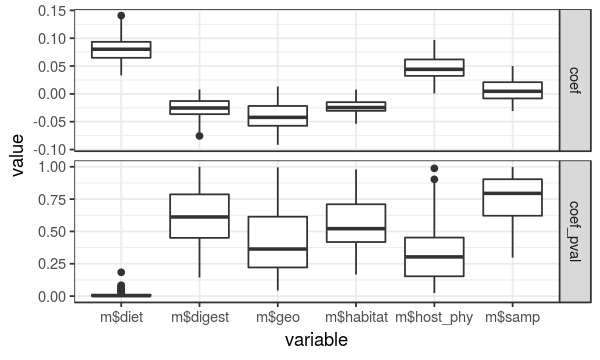

In [57]:
mrm_res_s = mrm_res %>% 
    filter(variable != 'Int') %>%
    gather(category, value, -variable, -R2, -pval, -F, -rep)              

p = ggplot(mrm_res_s, aes(variable, value)) +
    geom_boxplot() +
    facet_grid(category ~ ., scales='free_y') +
    theme_bw()

options(repr.plot.width=5, repr.plot.height=3)
plot_write(p, file='MRM_IndD_evenness_model1.pdf')

In [58]:
# significance
mrm_res %>% 
    group_by(variable) %>%
    summarize(pval_sensitivity = 1 - sum(coef_pval < 0.05) / length(pval)) %>%
    ungroup() %>%
    mutate(sig_pval_sensitivity = pval_sensitivity < 0.05)

variable,pval_sensitivity,sig_pval_sensitivity
Int,1.00,FALSE
m$diet,0.07,FALSE
m$digest,1.00,FALSE
m$geo,0.99,FALSE
m$habitat,1.00,FALSE
m$host_phy,0.97,FALSE
m$samp,1.00,FALSE


#### Model 2

In [59]:
doParallel::registerDoParallel(threads)
x = as.list(1:length(m_perm))
f = 'm$alpha ~ m$host_phy + m$diet + m$habitat + m$geo + m$samp'
mrm_res = plyr::llply(x, mrm_each, L=m_perm, f=f, nperm=nperm, .parallel=TRUE)
mrm_res = do.call(rbind, mrm_res)
mrm_res %>% dfhead

[1] 600   7


,coef,coef_pval,variable,R2,pval,F,rep
Int,3.713859e+03,0.834,Int,0.01013162,0.256,16.62626,1
m$host_phy,6.957522e-02,0.109,m$host_phy,0.01013162,0.256,16.62626,1
m$diet,6.564507e-02,0.013,m$diet,0.01013162,0.256,16.62626,1


In [60]:
# summary of overall model
mrm_res %>%
    distinct(R2, pval, rep) %>%
    summary

       R2                pval             rep        
 Min.   :0.005541   Min.   :0.0140   Min.   :  1.00  
 1st Qu.:0.009810   1st Qu.:0.1220   1st Qu.: 25.75  
 Median :0.011713   Median :0.1815   Median : 50.50  
 Mean   :0.011839   Mean   :0.2094   Mean   : 50.50  
 3rd Qu.:0.013595   3rd Qu.:0.2657   3rd Qu.: 75.25  
 Max.   :0.023288   Max.   :0.5690   Max.   :100.00  

Warning message:
“Removed 1 rows containing missing values (geom_point).”

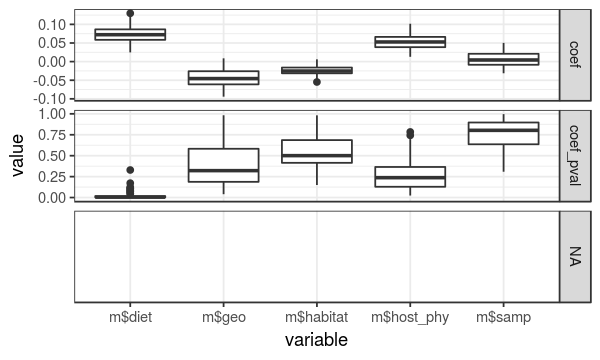

In [61]:
mrm_res_s = mrm_res %>% 
    filter(variable != 'Int') %>%
    gather(category, value, -variable, -R2, -pval, -F, -rep)              

# changing coef scale
df = mrm_res_s %>%
    filter(category == 'Coef.') %>%
    mutate(value = 0.41) %>%
    .[1,]

# plotting
p = ggplot(mrm_res_s, aes(variable, value)) +
    geom_boxplot() +
    geom_point(data=df, alpha=0) +
    facet_grid(category ~ ., scales='free_y') +
    theme_bw()

options(repr.plot.width=5, repr.plot.height=3)
plot(p, file='MRM_IndD_evenness_model2.pdf')

In [62]:
# significance
mrm_res %>% 
    group_by(variable) %>%
    summarize(pval_sensitivity = 1 - sum(coef_pval < 0.05) / length(pval)) %>%
    ungroup() %>%
    mutate(sig_pval_sensitivity = pval_sensitivity < 0.05)

variable,pval_sensitivity,sig_pval_sensitivity
Int,1.00,FALSE
m$diet,0.08,FALSE
m$geo,0.98,FALSE
m$habitat,1.00,FALSE
m$host_phy,0.94,FALSE
m$samp,1.00,FALSE


## One sample per host family

In [63]:
# grouping samples by species
df_grps = metadata %>% 
    filter(X.SampleID %in% labels(dietD_d_o)) %>%
    dplyr::select(X.SampleID, family)
df_grps %>% dfhead

[1] 213   2


X.SampleID,family
X1.Eurasian.Beaver,Castoridae
X101.Horse,Equidae
X102.Kulan,Equidae


### Faith's PD

In [64]:
# creating subsample permutations of the distance matrices
L = list(alpha = alpha_div$faith_pd,
         host_phy = host_tree_d_o,
         diet = dietD_d_o,
         digest = dtD_d_o, 
         habitat = habitatD_d_o,
         geo = geo_d_o,
         samp = samp_d_o)

m_perm = lapply(as.list(1:nperm_datasets), function(x) one_per_group(L, df_grps, x))
m_perm %>% length           

[1] 100

In [65]:
# check on sample size
m_perm[[1]][[1]] %>% as.matrix %>% dim

[1] 73 73

#### Model 1

In [66]:
doParallel::registerDoParallel(threads)
x = as.list(1:length(m_perm))
f = 'm$alpha ~ m$host_phy + m$diet + m$digest + m$habitat + m$geo + m$samp'
mrm_res = plyr::llply(x, mrm_each, L=m_perm, f=f, nperm=nperm, .parallel=TRUE)
mrm_res = do.call(rbind, mrm_res)
mrm_res %>% dfhead

[1] 700   7


,coef,coef_pval,variable,R2,pval,F,rep
Int,449.80849330,1.000,Int,0.214123,0.001,119.0213,1
m$host_phy,0.04930186,0.359,m$host_phy,0.214123,0.001,119.0213,1
m$diet,0.29515701,0.001,m$diet,0.214123,0.001,119.0213,1


In [67]:
# summary of overall model
mrm_res %>%
    distinct(R2, pval, rep) %>%
    summary

       R2               pval              rep        
 Min.   :0.07093   Min.   :0.00100   Min.   :  1.00  
 1st Qu.:0.10803   1st Qu.:0.00100   1st Qu.: 25.75  
 Median :0.12593   Median :0.00100   Median : 50.50  
 Mean   :0.12853   Mean   :0.00118   Mean   : 50.50  
 3rd Qu.:0.14418   3rd Qu.:0.00100   3rd Qu.: 75.25  
 Max.   :0.21412   Max.   :0.00600   Max.   :100.00  

Warning message:
“Column `variable`/`old_name` joining character vector and factor, coercing into character vector”

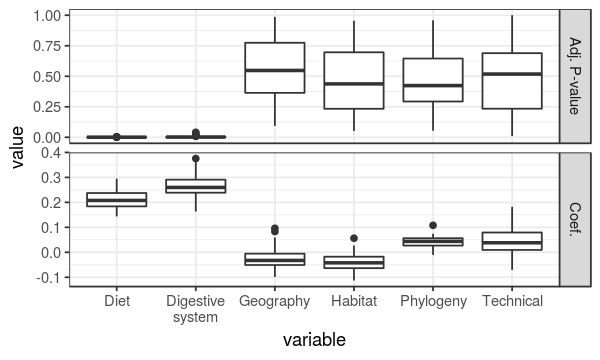

In [68]:
mrm_res_s = mrm_res %>% 
    filter(variable != 'Int') %>%
    gather(category, value, -variable, -R2, -pval, -F, -rep) %>%
    mutate(category = ifelse(category == 'coef', 'Coef.', 'Adj. P-value'))

mrm_res_s = mrm_res_s %>%
    inner_join(rename_df, c('variable'='old_name')) %>%
    dplyr::select(-variable) %>%
    rename('variable' = new_name)             

p = ggplot(mrm_res_s, aes(variable, value)) +
    geom_boxplot() +
    facet_grid(category ~ ., scales='free_y') +
    theme_bw()

options(repr.plot.width=5, repr.plot.height=3)
plot(p)

In [69]:
# significance
mrm_res %>% 
    group_by(variable) %>%
    summarize(pval_sensitivity = 1 - sum(coef_pval < 0.05) / length(pval)) %>%
    ungroup() %>%
    mutate(sig_pval_sensitivity = pval_sensitivity < 0.05)

variable,pval_sensitivity,sig_pval_sensitivity
Int,1.00,FALSE
m$diet,0.00,TRUE
m$digest,0.00,TRUE
m$geo,1.00,FALSE
m$habitat,1.00,FALSE
m$host_phy,1.00,FALSE
m$samp,0.93,FALSE


#### Model 2

In [70]:
doParallel::registerDoParallel(threads)
x = as.list(1:length(m_perm))
f = 'm$alpha ~ m$host_phy + m$diet + m$habitat + m$geo + m$samp'
mrm_res = plyr::llply(x, mrm_each, L=m_perm, f=f, nperm=nperm, .parallel=TRUE)
mrm_res = do.call(rbind, mrm_res)
mrm_res %>% dfhead

[1] 600   7


,coef,coef_pval,variable,R2,pval,F,rep
Int,764.06545413,0.997,Int,0.1653081,0.001,103.8558,1
m$host_phy,-0.04057595,0.401,m$host_phy,0.1653081,0.001,103.8558,1
m$diet,0.39988119,0.001,m$diet,0.1653081,0.001,103.8558,1


In [71]:
# summary of overall model
mrm_res %>%
    distinct(R2, pval, rep) %>%
    summary

       R2               pval              rep        
 Min.   :0.04900   Min.   :0.00100   Min.   :  1.00  
 1st Qu.:0.07150   1st Qu.:0.00100   1st Qu.: 25.75  
 Median :0.08820   Median :0.00100   Median : 50.50  
 Mean   :0.08975   Mean   :0.00225   Mean   : 50.50  
 3rd Qu.:0.10343   3rd Qu.:0.00200   3rd Qu.: 75.25  
 Max.   :0.16531   Max.   :0.01600   Max.   :100.00  

Warning message:
“Column `variable`/`old_name` joining character vector and factor, coercing into character vector”

File written: /ebio/abt3_projects/Georg_animal_feces/data/modulating_factors/MRM/IndD/alpha_div/.figures/MRM_IndD-family_faithPD_model2.pdf 


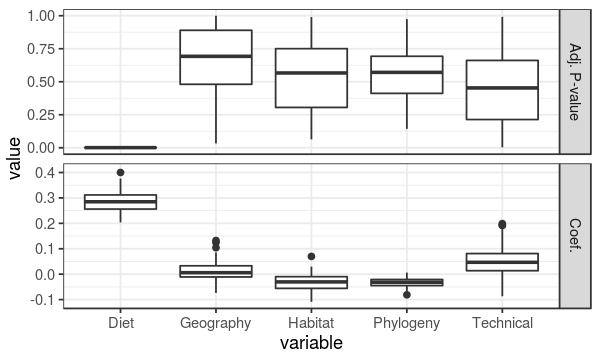

In [72]:
mrm_res_s = mrm_res %>% 
    filter(variable != 'Int') %>%
    gather(category, value, -variable, -R2, -pval, -F, -rep) %>%
    mutate(category = ifelse(category == 'coef', 'Coef.', 'Adj. P-value'))

mrm_res_s = mrm_res_s %>%
    inner_join(rename_df, c('variable'='old_name')) %>%
    dplyr::select(-variable) %>%
    rename('variable' = new_name)             

# changing coef scale
df = mrm_res_s %>%
    filter(category == 'Coef.') %>%
    mutate(value = 0.41) %>%
    .[1,]

# plotting
p = ggplot(mrm_res_s, aes(variable, value)) +
    geom_boxplot() +
    geom_point(data=df, alpha=0) +
    facet_grid(category ~ ., scales='free_y') +
    theme_bw()

options(repr.plot.width=5, repr.plot.height=3)
plot_write(p, file='MRM_IndD-family_faithPD_model2.pdf')

In [73]:
# significance
mrm_res %>% 
    group_by(variable) %>%
    summarize(pval_sensitivity = 1 - sum(coef_pval < 0.05) / length(pval)) %>%
    ungroup() %>%
    mutate(sig_pval_sensitivity = pval_sensitivity < 0.05)

variable,pval_sensitivity,sig_pval_sensitivity
Int,1.00,FALSE
m$diet,0.00,TRUE
m$geo,0.98,FALSE
m$habitat,1.00,FALSE
m$host_phy,1.00,FALSE
m$samp,0.92,FALSE


### Shannon

In [74]:
# creating multiple distance matrices
L = list(alpha = alpha_div$shannon,
         host_phy = host_tree_d_o,
         diet = dietD_d_o,
         digest = dtD_d_o, 
         habitat = habitatD_d_o,
         geo = geo_d_o,
         samp = samp_d_o)

m_perm = lapply(as.list(1:nperm_datasets), function(x) one_per_group(L, df_grps, x))
m_perm %>% length           

[1] 100

In [75]:
# check on sample size
m_perm[[1]][[1]] %>% as.matrix %>% dim

[1] 73 73

#### Model 1

In [76]:
doParallel::registerDoParallel(threads)
x = as.list(1:length(m_perm))
f = 'm$alpha ~ m$host_phy + m$diet + m$digest + m$habitat + m$geo + m$samp'
mrm_res = plyr::llply(x, mrm_each, L=m_perm, f=f, nperm=nperm, .parallel=TRUE)
mrm_res = do.call(rbind, mrm_res)
mrm_res %>% dfhead

[1] 700   7


,coef,coef_pval,variable,R2,pval,F,rep
Int,930.13273934,0.987,Int,0.04670829,0.008,21.40346,1
m$host_phy,0.04626924,0.354,m$host_phy,0.04670829,0.008,21.40346,1
m$diet,0.09888953,0.004,m$diet,0.04670829,0.008,21.40346,1


In [77]:
# summary of overall model
mrm_res %>%
    distinct(R2, pval, rep) %>%
    summary

       R2               pval              rep        
 Min.   :0.02062   Min.   :0.00100   Min.   :  1.00  
 1st Qu.:0.03908   1st Qu.:0.00100   1st Qu.: 25.75  
 Median :0.05146   Median :0.00300   Median : 50.50  
 Mean   :0.05364   Mean   :0.01466   Mean   : 50.50  
 3rd Qu.:0.06444   3rd Qu.:0.01250   3rd Qu.: 75.25  
 Max.   :0.11305   Max.   :0.19900   Max.   :100.00  

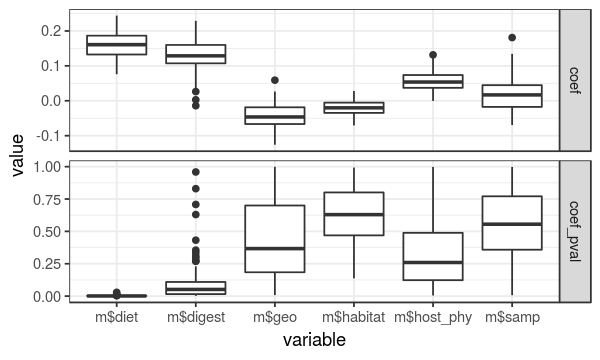

In [78]:
mrm_res_s = mrm_res %>% 
    filter(variable != 'Int') %>%
    gather(category, value, -variable, -R2, -pval, -F, -rep)              

p = ggplot(mrm_res_s, aes(variable, value)) +
    geom_boxplot() +
    facet_grid(category ~ ., scales='free_y') +
    theme_bw()

options(repr.plot.width=5, repr.plot.height=3)
plot(p)

In [79]:
# significance
mrm_res %>% 
    group_by(variable) %>%
    summarize(pval_sensitivity = 1 - sum(coef_pval < 0.05) / length(pval)) %>%
    ungroup() %>%
    mutate(sig_pval_sensitivity = pval_sensitivity < 0.05)

variable,pval_sensitivity,sig_pval_sensitivity
Int,1.00,FALSE
m$diet,0.00,TRUE
m$digest,0.51,FALSE
m$geo,0.99,FALSE
m$habitat,1.00,FALSE
m$host_phy,0.93,FALSE
m$samp,0.93,FALSE


#### Model 2

In [80]:
doParallel::registerDoParallel(threads)
x = as.list(1:length(m_perm))
f = 'm$alpha ~ m$host_phy + m$diet + m$habitat + m$geo + m$samp'
mrm_res = plyr::llply(x, mrm_each, L=m_perm, f=f, nperm=nperm, .parallel=TRUE)
mrm_res = do.call(rbind, mrm_res)
mrm_res %>% dfhead

[1] 600   7


,coef,coef_pval,variable,R2,pval,F,rep
Int,1.145803e+03,0.886,Int,0.0253367,0.048,13.63196,1
m$host_phy,-9.980423e-03,0.847,m$host_phy,0.0253367,0.048,13.63196,1
m$diet,1.549681e-01,0.001,m$diet,0.0253367,0.048,13.63196,1


In [81]:
# summary of overall model
mrm_res %>%
    distinct(R2, pval, rep) %>%
    summary

       R2               pval              rep        
 Min.   :0.01631   Min.   :0.00100   Min.   :  1.00  
 1st Qu.:0.03043   1st Qu.:0.00100   1st Qu.: 25.75  
 Median :0.04229   Median :0.00500   Median : 50.50  
 Mean   :0.04351   Mean   :0.01739   Mean   : 50.50  
 3rd Qu.:0.05417   3rd Qu.:0.02100   3rd Qu.: 75.25  
 Max.   :0.09334   Max.   :0.21600   Max.   :100.00  

Warning message:
“Column `variable`/`old_name` joining character vector and factor, coercing into character vector”

File written: /ebio/abt3_projects/Georg_animal_feces/data/modulating_factors/MRM/IndD/alpha_div/.figures/MRM_IndD-family_shannon_model2.pdf 


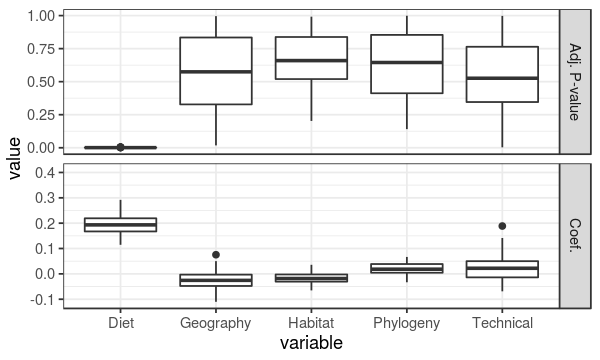

In [82]:
mrm_res_s = mrm_res %>% 
    filter(variable != 'Int') %>%
    gather(category, value, -variable, -R2, -pval, -F, -rep) %>%
    mutate(category = ifelse(category == 'coef', 'Coef.', 'Adj. P-value'))

mrm_res_s = mrm_res_s %>%
    inner_join(rename_df, c('variable'='old_name')) %>%
    dplyr::select(-variable) %>%
    rename('variable' = new_name)              

# changing coef scale
df = mrm_res_s %>%
    filter(category == 'Coef.') %>%
    mutate(value = 0.41) %>%
    .[1,]

# plotting
p = ggplot(mrm_res_s, aes(variable, value)) +
    geom_boxplot() +
    geom_point(data=df, alpha=0) +
    facet_grid(category ~ ., scales='free_y') +
    theme_bw()

options(repr.plot.width=5, repr.plot.height=3)
plot_write(p, file='MRM_IndD-family_shannon_model2.pdf')

In [83]:
# significance
mrm_res %>% 
    group_by(variable) %>%
    summarize(pval_sensitivity = 1 - sum(coef_pval < 0.05) / length(pval)) %>%
    ungroup() %>%
    mutate(sig_pval_sensitivity = pval_sensitivity < 0.05)

variable,pval_sensitivity,sig_pval_sensitivity
Int,1.00,FALSE
m$diet,0.00,TRUE
m$geo,0.99,FALSE
m$habitat,1.00,FALSE
m$host_phy,1.00,FALSE
m$samp,0.94,FALSE


# sessionInfo


In [84]:
sessionInfo()

R version 3.4.1 (2017-06-30)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.1 LTS

Matrix products: default
BLAS: /ebio/abt3_projects/software/miniconda3_gt4.4/envs/py3_physeq_eco/lib/R/lib/libRblas.so
LAPACK: /ebio/abt3_projects/software/miniconda3_gt4.4/envs/py3_physeq_eco/lib/R/lib/libRlapack.so

locale:
[1] en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] bindrcpp_0.2.2  phyloseq_1.22.3 stringr_1.3.1   ggplot2_3.0.0  
[5] tidyr_0.8.1     dplyr_0.7.6    

loaded via a namespace (and not attached):
 [1] Rcpp_0.12.17        ape_5.1             lattice_0.20-34    
 [4] Biostrings_2.46.0   assertthat_0.2.0    digest_0.6.15      
 [7] foreach_1.4.4       IRdisplay_0.4.4     R6_2.2.2           
[10] plyr_1.8.4          repr_0.15.0         stats4_3.4.1       
[13] evaluate_0.10.1     pillar_1.2.2        zlibbioc_1.24.0    
[16] rlang_0.2.1         lazyeval_0.2.1      uuid_0.1-2  